Loading Train Data

In [ ]:
# Specify the file path from where to load the arrays
file_path = "Datasetfinalhope.txt"

# Initialize empty arrays to store loaded data
input_texts = []
target_texts = []

# Open the file in read mode and load the arrays from the file
with open(file_path, "r") as file:
    for line in file:
        # Split each line into input and target using the tab ("\t") as a separator
        input_text, target_text = line.strip().split("\t")

        # Append the data to the respective arrays
        input_texts.append(input_text)
        target_texts.append(target_text)

# Print a message indicating that arrays are loaded
print(f"Arrays loaded from {file_path}")

Arrays loaded from Datasetfinalhope.txt


Input Texts contain original sentences and Target Texts contain simplified sentences

In [ ]:
len(input_texts)

4009

In [ ]:
input_texts[3555]

'The Wakker Prize (in German: Wakkerpreis, in French Prix Wakker, in Italian Premio Wakker) is awarded annually by the Swiss Heritage Society to a Municipality of Switzerland for the development and preservation of its architectural heritage.'

In [ ]:
target_texts[3555]

'The Wakker Prize is awarded every year by the Swiss Heritage Society to a Municipality of Switzerland for the development and preservation of its architectural heritage.'

Preprocessing

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pickle

# Tokenize the text data
tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', oov_token="<OOV>", lower=True)
tokenizer.fit_on_texts(input_texts + target_texts)

# Save the tokenizer for later use during testing
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Add the padding token to the word_index
padding_token_index = len(tokenizer.word_index) + 1
tokenizer.word_index['<PAD>'] = padding_token_index
tokenizer.index_word[padding_token_index] = '<PAD>'

# Convert text to sequences
input_sequences = tokenizer.texts_to_sequences(input_texts)
target_sequences = tokenizer.texts_to_sequences(target_texts)

# Padding sequences
max_sequence_length = 140  # Define the maximum sequence length
encoder_input_data = pad_sequences(input_sequences, maxlen=max_sequence_length, padding='post')
decoder_input_data = pad_sequences(target_sequences, maxlen=max_sequence_length, padding='post')

# Generate decoder target data
decoder_target_data = np.zeros_like(decoder_input_data)
decoder_target_data[:, 0:-1] = decoder_input_data[:, 1:]
decoder_target_data[:, -1] = padding_token_index  # Use the index of the padding token

# Check Vocabulary Size Matching
input_vocab_size = len(tokenizer.word_index) + 1
target_vocab_size = len(tokenizer.word_index) + 1

if input_vocab_size != target_vocab_size:
    raise ValueError("Input and target vocabulary sizes do not match!")

2023-12-15 03:32:43.846021: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
input_vocab_size

10112

In [ ]:
target_vocab_size

10112

Using Pretrained Word2Vec

In [ ]:
from gensim.models import KeyedVectors
from keras.layers import Embedding
import numpy as np

# Specify the path to the Word2Vec model file
word2vec_model_path = 'GoogleNews-vectors-negative300.bin'

# Load the Google News Word2Vec model
word2vec_model = KeyedVectors.load_word2vec_format(word2vec_model_path, binary=True)

# Check Word2Vec Coverage
covered_words = sum(1 for word in tokenizer.word_index if word in word2vec_model)
total_words = len(tokenizer.word_index)

coverage_percentage = (covered_words / total_words) * 100

print("Word2Vec Coverage: {:.2f}%".format(coverage_percentage))

# Get the number of unique tokens from your tokenizer
num_encoder_tokens = len(tokenizer.word_index) + 1  # Add 1 for the zero-padding token

# Create an embedding matrix
embedding_matrix = np.zeros((num_encoder_tokens, word2vec_model.vector_size))
for word, i in tokenizer.word_index.items():
    if word in word2vec_model:
        embedding_matrix[i] = word2vec_model[word]

# Create the embedding layer
encoder_embedding_layer = Embedding(
    num_encoder_tokens,
    word2vec_model.vector_size,
    weights=[embedding_matrix],
    input_length=max_sequence_length,
    trainable=False
)

Word2Vec Coverage: 79.14%


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Bidirectional, Concatenate, Attention, GlobalMaxPooling1D, LayerNormalization, Dropout, Add
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Convert data to tensors
encoder_input_data = tf.convert_to_tensor(encoder_input_data, dtype=tf.float32)
decoder_input_data = tf.convert_to_tensor(decoder_input_data, dtype=tf.float32)
decoder_target_data = tf.convert_to_tensor(decoder_target_data, dtype=tf.float32)

2023-12-15 03:33:35.567703: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-15 03:33:35.687843: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [ ]:
print("Encoder Input Data Shape:", encoder_input_data.shape)
print("Decoder Input Data Shape:", decoder_input_data.shape)
print("Decoder Target Data Shape:", decoder_target_data.shape)

Encoder Input Data Shape: (4009, 140)
Decoder Input Data Shape: (4009, 140)
Decoder Target Data Shape: (4009, 140)


In [ ]:
# Define the parameters
latent_dim = 120
num_encoder_tokens = len(tokenizer.word_index) + 1  # Adjust according to your data
num_decoder_tokens = len(tokenizer.word_index) + 1  # Adjust according to your data

Training the Model (1)

In [ ]:
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Concatenate, Attention, Dense, LayerNormalization, Dropout, Add
from tensorflow.keras.models import Model

# Define the encoder
encoder_inputs = Input(shape=(None,))
encoder_embedding = encoder_embedding_layer(encoder_inputs)  # Assuming encoder_embedding_layer is already defined
encoder_bi_lstm = Bidirectional(LSTM(latent_dim, return_sequences=True, return_state=True))
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_bi_lstm(encoder_embedding)
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])

# Define the decoder
decoder_inputs = Input(shape=(None,))
decoder_embedding = Embedding(num_decoder_tokens, latent_dim, mask_zero=True)(decoder_inputs)

# Update the initial state to match the expected state_size of the LSTM cell
decoder_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=[state_h, state_c])

attention = Attention()([decoder_outputs, encoder_outputs])
decoder_concat = Concatenate(axis=-1)([decoder_outputs, attention])
decoder_dense_2 = Dense(latent_dim*2, activation='relu')
decoder_norm = LayerNormalization()
decoder_dropout = Dropout(0.5)
decoder_outputs_2 = decoder_dense_2(decoder_concat)
decoder_outputs_2_norm = decoder_norm(decoder_outputs_2)
decoder_outputs_2_dropout = decoder_dropout(decoder_outputs_2_norm)

# Ensure the dimensions are compatible during the residual connection
decoder_residual = Add()([decoder_outputs, decoder_outputs_2_dropout])

# Define the final Dense layer
final_decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs_final = final_decoder_dense(decoder_residual)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs_final)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 300)    3033600     ['input_3[0][0]']                
                                                                                                  
 input_4 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 bidirectional_1 (Bidirectional  [(None, None, 240),  404160     ['embedding[1][0]']              
 )                               (None, 120),                                               

2023-12-14 18:01:34.777351: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 3099 num_cores: 12 environment { key: "cpu_instruction_set" value: "SSE, SSE2, SSE3" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 12582912 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


101/101 [==============================] - ETA: 0s - loss: 7.3502 - accuracy: 0.0805

2023-12-14 18:04:54.239938: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 3099 num_cores: 12 environment { key: "cpu_instruction_set" value: "SSE, SSE2, SSE3" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 12582912 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


101/101 [==============================] - 220s 2s/step - loss: 7.3502 - accuracy: 0.0805 - val_loss: 6.9271 - val_accuracy: 0.0904
Epoch 2/100
101/101 [==============================] - 204s 2s/step - loss: 6.7512 - accuracy: 0.1026 - val_loss: 6.6187 - val_accuracy: 0.1215
Epoch 3/100
101/101 [==============================] - 195s 2s/step - loss: 6.3838 - accuracy: 0.1330 - val_loss: 6.3743 - val_accuracy: 0.1401
Epoch 4/100
101/101 [==============================] - 187s 2s/step - loss: 6.0591 - accuracy: 0.1478 - val_loss: 6.0350 - val_accuracy: 0.1528
Epoch 5/100
101/101 [==============================] - 198s 2s/step - loss: 5.7023 - accuracy: 0.1634 - val_loss: 5.7036 - val_accuracy: 0.1747
Epoch 6/100
101/101 [==============================] - 190s 2s/step - loss: 5.3152 - accuracy: 0.1827 - val_loss: 5.3445 - val_accuracy: 0.1899
Epoch 7/100
101/101 [==============================] - 186s 2s/step - loss: 4.9032 - accuracy: 0.2011 - val_loss: 4.9693 - val_accuracy: 0.2065
Epoc

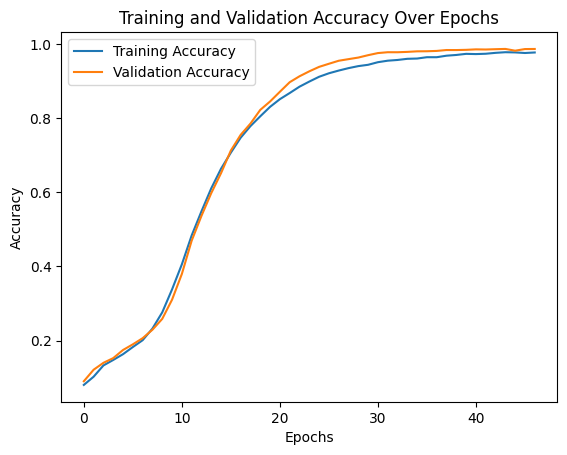

In [ ]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Compile the model with the EarlyStopping callback
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Fit the model with early stopping
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                    batch_size=32,
                    epochs=100,
                    validation_split=0.2,
                    callbacks=[early_stopping])

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()

In [ ]:
# Save the model
model.save('model1.h5')

# Save the model in the native Keras format
model.save('model1.keras')

# Optionally, saving model's weights separately
model.save_weights('model1_weights.h5')

Training the Model(2)

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 140)]        0           []                               
                                                                                                  
 embedding_7 (Embedding)        (None, 140, 300)     3033600     ['input_15[0][0]']               
                                                                                                  
 input_16 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 bidirectional_7 (Bidirectional  [(None, 140, 180),  281520      ['embedding_7[1][0]']            
 )                               (None, 90),                                                

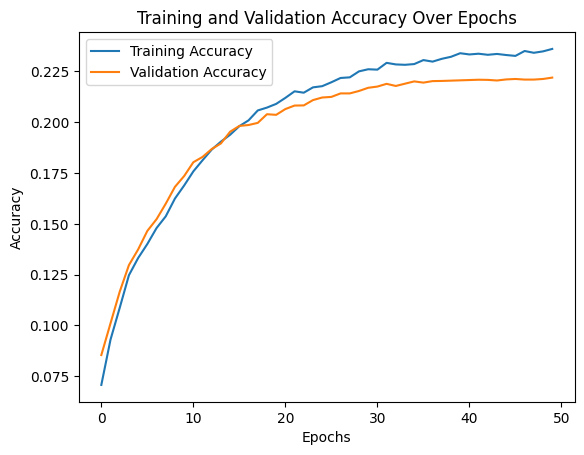

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Bidirectional, Concatenate, Attention
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dropout

# Convert data to tensors
encoder_input_data = tf.convert_to_tensor(encoder_input_data, dtype=tf.float32)
decoder_input_data = tf.convert_to_tensor(decoder_input_data, dtype=tf.float32)
decoder_target_data = tf.convert_to_tensor(decoder_target_data, dtype=tf.float32)

# Define the parameters
latent_dim = 90
num_encoder_tokens = len(tokenizer.word_index) + 1  # Adjust according to your data
num_decoder_tokens = len(tokenizer.word_index) + 1  # Adjust according to your data

# Define the encoder
encoder_inputs = Input(shape=(max_sequence_length,))
encoder_embedding = encoder_embedding_layer(encoder_inputs)
encoder_bi_lstm = Bidirectional(LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.2, recurrent_dropout=0.2))
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_bi_lstm(encoder_embedding)
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])

# Define the decoder
decoder_inputs = Input(shape=(None,))
decoder_embedding = Embedding(num_decoder_tokens, latent_dim, mask_zero=True)(decoder_inputs)
decoder_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True, dropout=0.2, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=[state_h, state_c])
attention = Attention()([decoder_outputs, encoder_outputs])
decoder_concat = tf.keras.layers.concatenate([decoder_outputs, attention], axis=-1)

# Additional Dense Layer
decoder_dense_2 = Dense(latent_dim, activation='relu')
decoder_outputs_2 = decoder_dense_2(decoder_concat)
decoder_dropout = Dropout(0.2)(decoder_outputs_2)  # Apply Dropout directly to the output

# Final Dense Layer
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_dropout)  # Use the output after applying Dropout


# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Learning Rate Schedule
def lr_schedule(epoch):
    return 0.001 * np.exp(-epoch / 10)

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

# Train the model
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                    batch_size=32,
                    epochs=50,
                    validation_split=0.2,callbacks=[lr_callback]
                    )

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()

In [ ]:
# Save the model
model.save('model2.h5')

# Save the model in the native Keras format
model.save('model2.keras')

# Optionally, saving model's weights separately
model.save_weights('model2_weights.h5')

Model -3

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 140)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 140, 300)     3033600     ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 bidirectional (Bidirectional)  [(None, 140, 180),   281520      ['embedding[0][0]']              
                                 (None, 90),                                                  

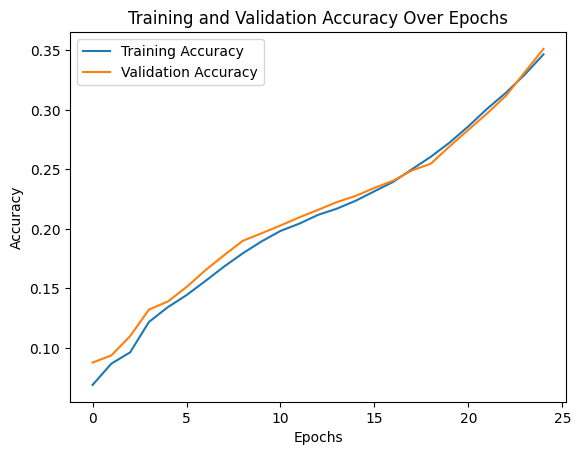

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Bidirectional, Concatenate, Attention
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dropout

# Convert data to tensors
encoder_input_data = tf.convert_to_tensor(encoder_input_data, dtype=tf.float32)
decoder_input_data = tf.convert_to_tensor(decoder_input_data, dtype=tf.float32)
decoder_target_data = tf.convert_to_tensor(decoder_target_data, dtype=tf.float32)

# Define the parameters
latent_dim = 90
num_encoder_tokens = len(tokenizer.word_index) + 1  # Adjust according to your data
num_decoder_tokens = len(tokenizer.word_index) + 1  # Adjust according to your data

# Define the encoder
encoder_inputs = Input(shape=(max_sequence_length,))
encoder_embedding = encoder_embedding_layer(encoder_inputs)
encoder_bi_lstm = Bidirectional(LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.2, recurrent_dropout=0.2))
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_bi_lstm(encoder_embedding)
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])

# Define the decoder
decoder_inputs = Input(shape=(None,))
decoder_embedding = Embedding(num_decoder_tokens, latent_dim, mask_zero=True)(decoder_inputs)
decoder_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True, dropout=0.2, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=[state_h, state_c])
attention = Attention()([decoder_outputs, encoder_outputs])
decoder_concat = tf.keras.layers.concatenate([decoder_outputs, attention], axis=-1)

# Additional Dense Layer
decoder_dense_2 = Dense(latent_dim, activation='relu')
decoder_outputs_2 = decoder_dense_2(decoder_concat)
decoder_dropout = Dropout(0.2)(decoder_outputs_2)  # Apply Dropout directly to the output

# Final Dense Layer
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_dropout)  # Use the output after applying Dropout


# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Learning Rate Schedule
#def lr_schedule(epoch):
#    return 0.001 * np.exp(-epoch / 10)

#lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)
#callbacks=[lr_callback]
# Train the model
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                    batch_size=32,
                    epochs=25,
                    validation_split=0.3
                    )

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()

Testing (On Model-1)

Loading Test Data

In [ ]:
# Specify the file path from where to load the arrays
file_path = "test300+150.txt"

# Initialize empty arrays to store loaded data
test_input_texts = []
test_target_texts = []

# Open the file in read mode and load the arrays from the file
with open(file_path, "r") as file:
    for line in file:
        # Split each line into input and target using the tab ("\t") as a separator
        input_text, target_text = line.strip().split("\t")

        # Append the data to the respective arrays
        test_input_texts.append(input_text)
        test_target_texts.append(target_text)

# Print a message indicating that arrays are loaded
print(f"Arrays loaded from {file_path}")

Arrays loaded from test300+150.txt


In [ ]:
pip install rouge

Evaluation on entire test data

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pickle
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from nltk.translate.bleu_score import sentence_bleu

# Load the tokenizer from the saved file
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

# Tokenize the test data
test_encoder_sequences = tokenizer.texts_to_sequences(test_input_texts)
test_decoder_sequences = tokenizer.texts_to_sequences(test_target_texts)

# Pad the sequences
max_seq_length = max(max(len(seq) for seq in test_encoder_sequences), max(len(seq) for seq in test_decoder_sequences))
test_encoder_input_data = pad_sequences(test_encoder_sequences, maxlen=max_seq_length, padding='post')
test_decoder_input_data = pad_sequences(test_decoder_sequences, maxlen=max_seq_length, padding='post')

# Convert data to tensors
test_encoder_input_data = tf.convert_to_tensor(test_encoder_input_data, dtype=tf.int32)
test_decoder_input_data = tf.convert_to_tensor(test_decoder_input_data, dtype=tf.int32)

# Generate predictions using the trained model
predictions = model.predict([test_encoder_input_data, test_decoder_input_data])

# Convert predictions back to text
predicted_texts = []
for prediction in predictions:
    predicted_text = ' '.join([tokenizer.index_word.get(idx, '') for idx in np.argmax(prediction, axis=1)])
    predicted_texts.append(predicted_text)

# Convert ground truth data back to text
ground_truth_texts = test_target_texts

# Calculate BLEU score
references = [[text.split()] for text in ground_truth_texts]
candidates = [text.split() for text in predicted_texts]
bleu_score = corpus_bleu(references, candidates)
print(f"BLEU Score: {bleu_score * 100:.2f}%")

# Calculate BLEU score with smoothing
smoothing_function = SmoothingFunction().method4
bleu_score_smoothed = corpus_bleu(references, candidates, smoothing_function=smoothing_function)
print(f"BLEU Score with Smoothing: {bleu_score_smoothed * 100:.2f}%")

# Calculate ROUGE score
reference_string = ' '.join(ground_truth_texts)
hypothesis_string = ' '.join(predicted_texts)

rouge_n_score = sentence_bleu(reference_string, hypothesis_string, weights=(1, 0, 0, 0))
rouge_l_score = sentence_bleu(reference_string, hypothesis_string, weights=(0, 1, 0, 0))

print(f"ROUGE-N Score: {rouge_n_score * 100:.2f}%")
print(f"ROUGE-L Score: {rouge_l_score * 100:.2f}%")


2023-12-14 22:21:04.993376: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "101" frequency: 3099 num_cores: 12 environment { key: "cpu_instruction_set" value: "SSE, SSE2, SSE3" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 12582912 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


15/15 [==============================] - 5s 193ms/step
BLEU Score: 16.07%
BLEU Score with Smoothing: 16.07%
ROUGE-N Score: 0.08%
ROUGE-L Score: 0.00%


Evaluation on a random sentence using Beam Search Prediction

In [ ]:
# Example of using beam search during prediction

def beam_search_decoder(predictions, top_k=3):
    start = [tokenizer.word_index['<start>']]

    # Get the top K candidates at each step
    sequences = [[start, 0.0]]
    for _ in range(max_sequence_length):
        all_candidates = []
        for i in range(len(sequences)):
            seq, score = sequences[i]
            if seq[-1] == tokenizer.word_index['<end>']:
                all_candidates.append([seq, score])
                continue
            expanded = model.predict([np.array([seq[-1]]), np.array([seq])])
            predictions = expanded[0, -1, :]
            word_preds = np.argsort(predictions)[::-1][:top_k]
            for w in word_preds:
                next_seq, next_score = seq + [w], score - np.log(predictions[w])
                all_candidates.append([next_seq, next_score])
        sequences = sorted(all_candidates, key=lambda x: x[1])[:top_k]

    return sequences

# Generate predictions using the trained model
predictions = model.predict([test_encoder_input_data, test_decoder_input_data])

# Convert predictions back to text
predicted_texts = []
for prediction in predictions:
    predicted_text = ' '.join([tokenizer.index_word.get(idx, '') for idx in np.argmax(prediction, axis=1)])
    predicted_text = predicted_text.replace('<start>', '').replace('<end>', '').strip()
    predicted_text = predicted_text.capitalize() + '.'  # Capitalize first letter and add a period
    predicted_texts.append(predicted_text)

# Convert ground truth data back to text
ground_truth_texts = test_target_texts

# Print the original, actual simplified, and predicted simplified sentences for a random example
index = 449
input_sentence = test_input_texts[index]
actual_simplified_sentence = test_target_texts[index]
predicted_sentence = predicted_texts[index]

print("Original Sentence:", input_sentence)
print("Actual Simplified Sentence:", actual_simplified_sentence)
print("Predicted Simplified Sentence:", predicted_sentence)

# Calculate BLEU score
references = [[text.split()] for text in ground_truth_texts]
candidates = [text.split() for text in predicted_texts]
bleu_score = corpus_bleu(references, candidates)

# Print the BLEU score
print(f"BLEU score: {bleu_score}")

# Calculate BLEU score with smoothing
smoothing_function = SmoothingFunction().method4
bleu_score = corpus_bleu(references, candidates, smoothing_function=smoothing_function)

# Print the BLEU score with smoothing
print(f"BLEU score with smoothing: {bleu_score}")

# Calculate ROUGE score
reference_string = ' '.join(ground_truth_texts)
hypothesis_string = ' '.join(predicted_texts)

rouge_n_score = sentence_bleu(reference_string, hypothesis_string, weights=(1, 0, 0, 0))
rouge_l_score = sentence_bleu(reference_string, hypothesis_string, weights=(0, 1, 0, 0))

print(f"ROUGE-N Score: {rouge_n_score * 100:.2f}%")
print(f"ROUGE-L Score: {rouge_l_score * 100:.2f}%")

15/15 [==============================] - 3s 174ms/step
Original Sentence: He is released back into the wild, now with more adult feathers, and a tracking device strapped to his back, and leads the humans home to his native colony.
Actual Simplified Sentence: He is put back into the wild, now with more adult feathers, and a tracking device strapped to his back.  He leads the humans home to his native colony.
Predicted Simplified Sentence: Is put back into the wild now with more adult feathers and a tracking device strapped to his back he leads the humans home to the native colony  of of of of of of of of of of of of of of of of.
BLEU score: 0.15682101300022366
BLEU score with smoothing: 0.15682101300022366
ROUGE-N Score: 0.15%
ROUGE-L Score: 0.00%


In [ ]:
# Example of using beam search during prediction

def beam_search_decoder(predictions, top_k=3):
    start = [tokenizer.word_index['<start>']]

    # Get the top K candidates at each step
    sequences = [[start, 0.0]]
    for _ in range(max_sequence_length):
        all_candidates = []
        for i in range(len(sequences)):
            seq, score = sequences[i]
            if seq[-1] == tokenizer.word_index['<end>']:
                all_candidates.append([seq, score])
                continue
            expanded = model.predict([np.array([seq[-1]]), np.array([seq])])
            predictions = expanded[0, -1, :]
            word_preds = np.argsort(predictions)[::-1][:top_k]
            for w in word_preds:
                next_seq, next_score = seq + [w], score - np.log(predictions[w])
                all_candidates.append([next_seq, next_score])
        sequences = sorted(all_candidates, key=lambda x: x[1])[:top_k]

    return sequences

# Generate predictions using the trained model
predictions = model.predict([test_encoder_input_data, test_decoder_input_data])

# Convert predictions back to text
predicted_texts = []
for prediction in predictions:
    predicted_text = ' '.join([tokenizer.index_word.get(idx, '') for idx in np.argmax(prediction, axis=1)])
    predicted_text = predicted_text.replace('<start>', '').replace('<end>', '').strip()
    predicted_text = predicted_text.capitalize() + '.'  # Capitalize first letter and add a period
    predicted_texts.append(predicted_text)

# Convert ground truth data back to text
ground_truth_texts = test_target_texts

# Print the original, actual simplified, and predicted simplified sentences for a random example
#index = np.random.randint(0, len(test_input_texts))
index = 298
input_sentence = test_input_texts[index]
actual_simplified_sentence = test_target_texts[index]
predicted_sentence = predicted_texts[index]

print("Original Sentence:", input_sentence)
print("Actual Simplified Sentence:", actual_simplified_sentence)
print("Predicted Simplified Sentence:", predicted_sentence)

# Calculate BLEU score
references = [[text.split()] for text in ground_truth_texts]
candidates = [text.split() for text in predicted_texts]
bleu_score = corpus_bleu(references, candidates)

# Print the BLEU score
print(f"BLEU score: {bleu_score}")

# Calculate BLEU score with smoothing
smoothing_function = SmoothingFunction().method4
bleu_score = corpus_bleu(references, candidates, smoothing_function=smoothing_function)

# Print the BLEU score with smoothing
print(f"BLEU score with smoothing: {bleu_score}")

# Calculate ROUGE score
reference_string = ' '.join(ground_truth_texts)
hypothesis_string = ' '.join(predicted_texts)

rouge_n_score = sentence_bleu(reference_string, hypothesis_string, weights=(1, 0, 0, 0))
rouge_l_score = sentence_bleu(reference_string, hypothesis_string, weights=(0, 1, 0, 0))

print(f"ROUGE-N Score: {rouge_n_score * 100:.2f}%")
print(f"ROUGE-L Score: {rouge_l_score * 100:.2f}%")

15/15 [==============================] - 3s 177ms/step
Original Sentence: Furthermore, she appeared in several music videos, including "It Girl" by John Oates and "Just Lose It" by Eminem.
Actual Simplified Sentence: She was in music videos, including "It Girl" by John Oates and "Just Lose It" by Eminem.
Predicted Simplified Sentence: Was popular several popular such popular was she she r and she he start was not have of of of of of of of of of of of of of of of of of of of of of of of of of of of of.
BLEU score: 0.15682101300022366
BLEU score with smoothing: 0.15682101300022366


/home/student/anaconda3/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/student/anaconda3/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/student/anaconda3/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or us

ROUGE-N Score: 0.15%
ROUGE-L Score: 0.00%


Evaluation of a random sentence

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction, sentence_bleu
from nltk.translate.meteor_score import single_meteor_score

# Manually set the index for '<START>' based on your training configuration
start_token_index = 1  # Adjust this based on your training data
oov_token_index = tokenizer.word_index.get('<OOV>', None) or len(tokenizer.word_index) + 1  # Get the index or assign a new one

# Encode the input sentence
test_input_sequence = tokenizer.texts_to_sequences(["In 1987 Wexler was inducted into the Rock and Roll Hall of Fame."])
encoder_test_input_data = pad_sequences(test_input_sequence, maxlen=max_sequence_length, padding='post')
encoder_test_input_data = tf.convert_to_tensor(encoder_test_input_data, dtype=tf.float32)

# Generate predictions using the trained model
decoder_test_input_data = np.zeros((1, max_sequence_length))
decoder_test_input_data[:, 0] = start_token_index  # Manually set the start token index
for i in range(1, max_sequence_length):
    predictions = model.predict([encoder_test_input_data, decoder_test_input_data])
    predicted_token = np.argmax(predictions[0, i-1, :])
    decoder_test_input_data[:, i] = predicted_token
    if predicted_token == 0:
        continue  # Skip the zero index
    if tokenizer.index_word[predicted_token] == '<END>':
        break

# Convert predicted sequence to text, replacing OOV tokens
predicted_text = [tokenizer.index_word.get(int(idx), '<OOV>') for idx in decoder_test_input_data[0] if idx != 0]
predicted_text[0] = predicted_text[0].capitalize()
predicted_text = " ".join(predicted_text) + "."

# Print the results
original_sentence = "In 1987 Wexler was inducted into the Rock and Roll Hall of Fame.."
simplified_sentence = "In 1987 Wexler was recognized into the Rock and Roll Hall of Fame."
print("Original Sentence:", original_sentence)
print("Simplified Sentence (Ground Truth):", simplified_sentence)
print("Predicted Simplified Sentence:", predicted_text)

# Calculate BLEU score
reference = [simplified_sentence.split()]
hypothesis = predicted_text.split()
bleu_score = corpus_bleu(reference, [hypothesis])
print(f"BLEU Score: {bleu_score * 100:.2f}%")

# Calculate BLEU score with smoothing
smoothed_bleu_score = corpus_bleu(reference, [hypothesis], smoothing_function=SmoothingFunction().method1)
print(f"BLEU Score with smoothing: {smoothed_bleu_score * 100:.2f}%")

# Calculate Rouge score
rouge_n_score = sentence_bleu(reference, hypothesis, weights=(1, 0, 0, 0))
rouge_l_score = sentence_bleu(reference, hypothesis, weights=(0, 1, 0, 0))

print(f"ROUGE-N Score: {rouge_n_score * 100:.2f}%")
print(f"ROUGE-L Score: {rouge_l_score * 100:.2f}%")


1/1 [==============================] - 0s 66ms/step
Original Sentence: In 1987 Wexler was inducted into the Rock and Roll Hall of Fame..
Simplified Sentence (Ground Truth): In 1987 Wexler was recognized into the Rock and Roll Hall of Fame.
Predicted Simplified Sentence: <oov> was put forth into the blues hall of fame hall and racehorse.
BLEU Score: 0.00%
BLEU Score with smoothing: 0.00%
ROUGE-N Score: 38.46%
ROUGE-L Score: 8.33%


Evaluation of a random sentence

In [ ]:
# Perform the necessary data preprocessing steps for the test data
# Assuming you have a tokenizer
# Tokenize the test data
test_encoder_sequences = tokenizer.texts_to_sequences(test_input_texts)
test_decoder_sequences = tokenizer.texts_to_sequences(test_target_texts)

# Pad the sequences
max_seq_length = max(max(len(seq) for seq in test_encoder_sequences), max(len(seq) for seq in test_decoder_sequences))
test_encoder_input_data = pad_sequences(test_encoder_sequences, maxlen=max_seq_length, padding='post')
test_decoder_input_data = pad_sequences(test_decoder_sequences, maxlen=max_seq_length, padding='post')

# Use the preprocessed test data as the test encoder and decoder input data for evaluation
test_encoder_input_data = test_encoder_input_data  # Adjust this based on your preprocessing
test_decoder_input_data = test_decoder_input_data  # Adjust this based on your preprocessing


# Evaluate the model using the test data
test_encoder_input_data = tf.convert_to_tensor(test_encoder_input_data, dtype=tf.float32)
test_decoder_input_data = tf.convert_to_tensor(test_decoder_input_data, dtype=tf.float32)

# Generate predictions using the trained model
predictions = model.predict([test_encoder_input_data, test_decoder_input_data])

# Convert predictions back to text
predicted_texts = []
for prediction in predictions:
    predicted_text = ' '.join([tokenizer.index_word.get(idx, '') for idx in np.argmax(prediction, axis=1)])
    predicted_texts.append(predicted_text)

# Convert ground truth data back to text
ground_truth_texts = test_target_texts

# Print the original, actual simplified, and predicted simplified sentences for a random example
index = np.random.randint(0, len(test_input_texts))
input_sentence = test_input_texts[index]
actual_simplified_sentence = test_target_texts[index]
predicted_sentence = predicted_texts[index]

print("Original Sentence:", input_sentence)
print("Actual Simplified Sentence:", actual_simplified_sentence)
print("Predicted Simplified Sentence:", predicted_sentence)


# Calculate BLEU score
references = [[text.split()] for text in ground_truth_texts]
candidates = [text.split() for text in predicted_texts]
bleu_score = corpus_bleu(references, candidates)

# Print the BLEU score
print(f"BLEU score: {bleu_score}")

from nltk.translate.bleu_score import SmoothingFunction

# Calculate BLEU score with smoothing
smoothing_function = SmoothingFunction().method4
bleu_score = corpus_bleu(references, candidates, smoothing_function=smoothing_function)

# Print the BLEU score
print(f"BLEU score with smoothing: {bleu_score}")

# Calculate Rouge score
rouge_n_score = sentence_bleu(reference, hypothesis, weights=(1, 0, 0, 0))
rouge_l_score = sentence_bleu(reference, hypothesis, weights=(0, 1, 0, 0))

print(f"ROUGE-N Score: {rouge_n_score * 100:.2f}%")
print(f"ROUGE-L Score: {rouge_l_score * 100:.2f}%")

15/15 [==============================] - 2s 157ms/step
Original Sentence: Offenbach's numerous operettas, such as Orpheus in the Underworld, and La belle Hélène, were extremely popular in both France and the English-speaking world during the 1850s and 1860s.
Actual Simplified Sentence: Offenbach composed numerous operettas, such as Orpheus in the Underworld and La belle Helene.  His operettas were very popular in France and English-speaking countries in the 1850s and 1860s.
Predicted Simplified Sentence: gave published churros in the 122 as san garden king paris english guard  current were many most by the  coptic  the  the english                  
BLEU score: 0.16072221447412147
BLEU score with smoothing: 0.16072221447412147
ROUGE-N Score: 23.08%
ROUGE-L Score: 0.00%


In [ ]:
import tensorflow as tf
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction
import pickle

# Load the tokenizer used during training
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

# Get the index or assign a new one for the '<OOV>' token
oov_token_index = tokenizer.word_index.get('<OOV>', None) or len(tokenizer.word_index) + 1

# Manually set the index for '<START>' based on your training configuration
start_token_index = 1  # Adjust this based on your training data

# Encode the input sentence
test_input_sequence = tokenizer.texts_to_sequences(["Due to some delays, her release date, with remissions, is currently 12 April 2024."])
encoder_test_input_data = pad_sequences(test_input_sequence, maxlen=max_sequence_length, padding='post')
encoder_test_input_data = tf.convert_to_tensor(encoder_test_input_data, dtype=tf.float32)

# Generate predictions using the trained model
decoder_test_input_data = np.zeros((1, max_sequence_length))
decoder_test_input_data[:, 0] = start_token_index  # Manually set the start token index
for i in range(1, max_sequence_length):
    predictions = model.predict([encoder_test_input_data, decoder_test_input_data])
    predicted_token = np.argmax(predictions[0, i-1, :])
    decoder_test_input_data[:, i] = predicted_token
    if predicted_token == 0:
        continue  # Skip the zero index
    if tokenizer.index_word[predicted_token] == '<END>':
        break

# Convert predicted sequence to text, replacing OOV tokens
predicted_text = " ".join([tokenizer.index_word.get(int(idx), '<OOV>') for idx in decoder_test_input_data[0] if idx != 0])

# Print the results
original_sentence = "Due to some delays, her release date, with remissions, is currently 12 April 2024."
simplified_sentence = "Her delayed release date is 12 April 2024."
print("Original Sentence:", original_sentence)
print("Simplified Sentence (Ground Truth):", simplified_sentence)
print("Predicted Simplified Sentence:", predicted_text)

# Calculate BLEU score
reference = [simplified_sentence.split()]
hypothesis = predicted_text.split()
bleu_score = sentence_bleu(reference, hypothesis)
print(f"BLEU Score: {bleu_score * 100:.2f}%")

# Calculate BLEU score with smoothing
smoothed_bleu_score = sentence_bleu(reference, hypothesis, smoothing_function=SmoothingFunction().method1)
print(f"BLEU Score with smoothing: {smoothed_bleu_score * 100:.2f}%")

# Calculate Rouge score
rouge_n_score = sentence_bleu(reference, hypothesis, weights=(1, 0, 0, 0))
rouge_l_score = sentence_bleu(reference, hypothesis, weights=(0, 1, 0, 0))

print(f"ROUGE-N Score: {rouge_n_score * 100:.2f}%")
print(f"ROUGE-L Score: {rouge_l_score * 100:.2f}%")

1/1 [==============================] - 0s 110ms/step
Original Sentence: Due to some delays, her release date, with remissions, is currently 12 April 2024.
Simplified Sentence (Ground Truth): Her delayed release date is 12 April 2024.
Predicted Simplified Sentence: <OOV> passes designs have 12 april 2024 with april 22
BLEU Score: 0.00%
BLEU Score with smoothing: 2.11%
ROUGE-N Score: 10.00%
ROUGE-L Score: 0.00%


Infering from unknown sentences of Research paper

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

# Assuming you have your model loaded, tokenizer, and other configurations

# Provided inference sentences
inference_sentences = [
    "The shortest path problem based on the data structure has become one of the hot research topics in graph theory.",
    "As the basic theory of solving this problem, Dijkstra algorithm has been widely used in engineering calculations.",
    "Aiming at the shortcomings of traditional Dijkstra algorithm, this paper has proposed an optimization method which has mainly improved the nodes selection of the shortest path and data storage structure and organization.",
    "Through comparison and analysis, the improved algorithm has been obtained, which has reduced the storage space, improved the operational efficiency and has a better applicability in the shortest path calculation.",
    "People's requirements for living and production efficiency have improved with the rapid development of computer science, in which the shortest path problem has become more prominent, and gradually becomes one of the hot topics of geographic information science, operations research, computer science and other disciplines.",
    "It is not only the key problem in network analysis but also the key issue in graph theory, and therefore it has been widely used in electronic navigation, network optimization, logistics, transportation and other areas in people's daily life.",
    "The shortest path is also the one between the nodes in the weighted graph of a data structure.",
    "Dijkstra algorithms used for calculating the shortest path, which was introduced by the famous Dutch computer scientist Eiziga.",
    "Dijkstra, was recognized as the best algorithm that can be applied to get the shortest path from a node to any other nodes."
]

# Load the tokenizer used during training
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

# Get the index or assign a new one for the '<OOV>' token
oov_token_index = tokenizer.word_index.get('<OOV>', None) or len(tokenizer.word_index) + 1

# Manually set the index for '<START>' based on your training configuration
start_token_index = 1  # Adjust this based on your training data

# Placeholder for the results
results = []

# Loop through inference sentences
for sentence in inference_sentences:
    # Encode the input sentence
    test_input_sequence = tokenizer.texts_to_sequences([sentence])
    encoder_test_input_data = pad_sequences(test_input_sequence, maxlen=max_sequence_length, padding='post')
    encoder_test_input_data = tf.convert_to_tensor(encoder_test_input_data, dtype=tf.float32)

    # Generate predictions using the trained model
    decoder_test_input_data = np.zeros((1, max_sequence_length))
    decoder_test_input_data[:, 0] = start_token_index  # Manually set the start token index
    for i in range(1, max_sequence_length):
        predictions = model.predict([encoder_test_input_data, decoder_test_input_data])
        predicted_token = np.argmax(predictions[0, i-1, :])
        decoder_test_input_data[:, i] = predicted_token
        if predicted_token == 0:
            continue  # Skip the zero index
        if tokenizer.index_word[predicted_token] == '<END>':
            break

    # Convert predicted sequence to text, replacing OOV tokens
    predicted_text = " ".join([tokenizer.index_word.get(int(idx), '<OOV>') for idx in decoder_test_input_data[0] if idx != 0])

    # Append results
    results.append({
        'original_sentence': sentence,
        'predicted_simplified_sentence': predicted_text
    })

# Display the results
for result in results:
    # Remove '<OOV>', capitalize the first word, and add a full stop
    predicted_simplified_sentence = ' '.join([word.capitalize() for word in result['predicted_simplified_sentence'].split() if word != '<OOV>']) + '.'

    print("Original Sentence:", result['original_sentence'])
    print("Predicted Simplified Sentence:", predicted_simplified_sentence)
    print()


1/1 [==============================] - 0s 108ms/step
Original Sentence: The shortest path problem based on the data structure has become one of the hot research topics in graph theory.
Predicted Simplified Sentence: It Is Become A Single Culture For The Most Of The Most System And Best Of World.

Original Sentence: As the basic theory of solving this problem, Dijkstra algorithm has been widely used in engineering calculations.
Predicted Simplified Sentence: The Igneous Theory Method Has Usually Be Also For Reduced Instruction Has Been Needed.

Original Sentence: Aiming at the shortcomings of traditional Dijkstra algorithm, this paper has proposed an optimization method which has mainly improved the nodes selection of the shortest path and data storage structure and organization.
Predicted Simplified Sentence: A Lot Of Slavery That 1835 A Iso Concrete But It Was Considered An Mass Of Makes It Possibly To Be The First Distribution.

Original Sentence: Through comparison and analysis, the